# Comprehensive EDA: 2 Years Historical Data
Extract, Clean, Analyze AQI and Weather Data

## 1. Import Required Libraries

In [68]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
sys.path.append(os.path.join(os.getcwd(), '..'))

## 2. Load & Fetch Historical Data (2 Years)

In [69]:
from dotenv import load_dotenv
load_dotenv()
LATITUDE = float(os.getenv('LATITUDE', 25.3792))
LONGITUDE = float(os.getenv('LONGITUDE', 68.3683))
TIMEZONE = os.getenv('TIMEZONE', 'Asia/Karachi')

In [70]:
from src.backend.api_client import fetch_historical_weather, fetch_historical_aqi

In [71]:
end_date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=730)).strftime("%Y-%m-%d")
weather_df = fetch_historical_weather(start_date=start_date, end_date=end_date, latitude=LATITUDE, longitude=LONGITUDE, timezone=TIMEZONE)
aqi_df = fetch_historical_aqi(start_date=start_date, end_date=end_date, latitude=LATITUDE, longitude=LONGITUDE, timezone=TIMEZONE)
df = pd.merge(weather_df, aqi_df, on='time', how='inner')
if 'us_aqi' in df.columns:
    df = df.rename(columns={'us_aqi': 'aqi'})
print(f"Dataset: {len(df)} records, {len(df.columns)} features\nDate range: {df['time'].min()} to {df['time'].max()}")
df.head(3)

Dataset: 17520 records, 13 features
Date range: 2024-02-17 19:00:00+00:00 to 2026-02-16 18:00:00+00:00


,time,temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,wind_direction_10m,precipitation,pm10,pm2_5,nitrogen_dioxide,sulphur_dioxide,carbon_monoxide,aqi
0,2024-02-17 19:00:00+00:00,20.400000,37.206779,1012.000000,14.917212,250.253067,0.0,28.000000,17.799999,11.5,10.6,346.0,78.484047
1,2024-02-17 20:00:00+00:00,19.799999,39.289436,1011.500000,16.904673,243.435013,0.0,29.500000,18.700001,10.8,10.5,336.0,77.180847
2,2024-02-17 21:00:00+00:00,19.150000,44.592751,1010.799988,17.873556,242.402786,0.0,29.799999,18.900000,9.9,10.1,321.0,76.117020


## 3. Data Cleaning & Preprocessing

In [72]:
def handle_missing_values(df):
    df_clean = df.copy()
    weather_vars = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m']
    for var in weather_vars:
        if var in df_clean.columns:
            df_clean[var] = df_clean[var].fillna(method='ffill', limit=3).interpolate(method='linear')
    if 'precipitation' in df_clean.columns:
        df_clean['precipitation'] = df_clean['precipitation'].fillna(0)
    if 'wind_direction_10m' in df_clean.columns:
        df_clean['wind_direction_10m'] = df_clean['wind_direction_10m'].fillna(method='ffill', limit=3).interpolate(method='linear')
    pollutant_vars = ['pm10', 'pm2_5', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'carbon_monoxide', 'aqi']
    for var in pollutant_vars:
        if var in df_clean.columns:
            df_clean[var] = df_clean[var].fillna(method='ffill', limit=2)
            df_clean[var] = df_clean[var].fillna(df_clean[var].rolling(window=12, min_periods=1, center=True).median())
    return df_clean

df_clean = handle_missing_values(df)
print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

Missing values after cleaning: 0


In [73]:
def detect_duplicate_weather(df, threshold=0.01):
    df_dup = df.copy()
    weather_features = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m', 'precipitation']
    is_duplicate = pd.Series(False, index=df_dup.index)
    for i in range(1, len(df_dup)):
        diffs = [abs(df_dup[f].iloc[i] - df_dup[f].iloc[i-1]) / (df_dup[f].max() - df_dup[f].min()) for f in weather_features if f in df_dup.columns and df_dup[f].max() - df_dup[f].min() > 0]
        if len(diffs) > 0 and all(d < threshold for d in diffs):
            is_duplicate.iloc[i] = True
    df_dup['is_duplicate'] = is_duplicate
    return df_dup

df_clean = detect_duplicate_weather(df_clean)
print(f"Duplicate weather patterns: {df_clean['is_duplicate'].sum()}")

Duplicate weather patterns: 204


In [74]:
def validate_data(df):
    checks = [('AQI', df['aqi'].min(), df['aqi'].max(), '0-600') if 'aqi' in df.columns else None,
              ('Temperature', df['temperature_2m'].min(), df['temperature_2m'].max(), '-40 to 60°C') if 'temperature_2m' in df.columns else None,
              ('Humidity', df['relative_humidity_2m'].min(), df['relative_humidity_2m'].max(), '0-100%') if 'relative_humidity_2m' in df.columns else None]
    return [c for c in checks if c]

for var, min_val, max_val, expected in validate_data(df_clean):
    print(f"{var}: {min_val:.1f} - {max_val:.1f} (expected: {expected})")

AQI: 33.7 - 167.0 (expected: 0-600)
Temperature: 7.3 - 49.0 (expected: -40 to 60°C)
Humidity: 3.3 - 99.7 (expected: 0-100%)


In [75]:
os.makedirs('../data', exist_ok=True)
df_clean.to_csv('../data/eda_cleaned_data_2years.csv', index=False)
print(f"Cleaned data saved: {len(df_clean)} records, {len(df_clean.columns)} features")

Cleaned data saved: 17520 records, 14 features


## 4. Data Quality Overview

In [76]:
df_clean.describe()

,temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,wind_direction_10m,precipitation,pm10,pm2_5,nitrogen_dioxide,sulphur_dioxide,carbon_monoxide,aqi
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,27.646000,52.534561,1007.751160,12.821775,194.039139,0.028019,56.052876,27.519682,8.806004,7.167334,467.827271,84.958275
std,7.401650,22.563843,7.581574,6.727311,101.143791,0.367569,34.096638,14.730530,8.112463,3.263777,419.979156,26.376505
min,7.300000,3.310669,989.400024,0.000000,0.690264,0.000000,4.300000,3.800000,0.000000,0.800000,97.000000,33.715275
25%,23.100000,34.400446,1001.599976,7.748368,164.054535,0.000000,34.700001,17.400000,3.100000,5.000000,196.000000,65.964094
50%,28.250000,52.308420,1007.900024,12.011544,223.898376,0.000000,48.099998,23.600000,6.300000,6.700000,300.000000,78.613945
75%,32.700001,71.593246,1014.200012,17.418196,243.435013,0.000000,68.000000,33.799999,11.300000,8.800000,599.000000,97.313828
max,49.049999,99.697578,1025.800049,43.976028,360.000000,12.800000,415.399994,105.500000,57.599998,29.900000,4083.000000,166.951767


In [77]:
df_clean.dtypes

time                    datetime64[ns, UTC]
temperature_2m                      float32
relative_humidity_2m                float32
pressure_msl                        float32
wind_speed_10m                      float32
wind_direction_10m                  float32
precipitation                       float32
pm10                                float32
pm2_5                               float32
nitrogen_dioxide                    float32
sulphur_dioxide                     float32
carbon_monoxide                     float32
aqi                                 float32
is_duplicate                           bool
dtype: object

## 5. Target Variable (AQI) Deep Dive

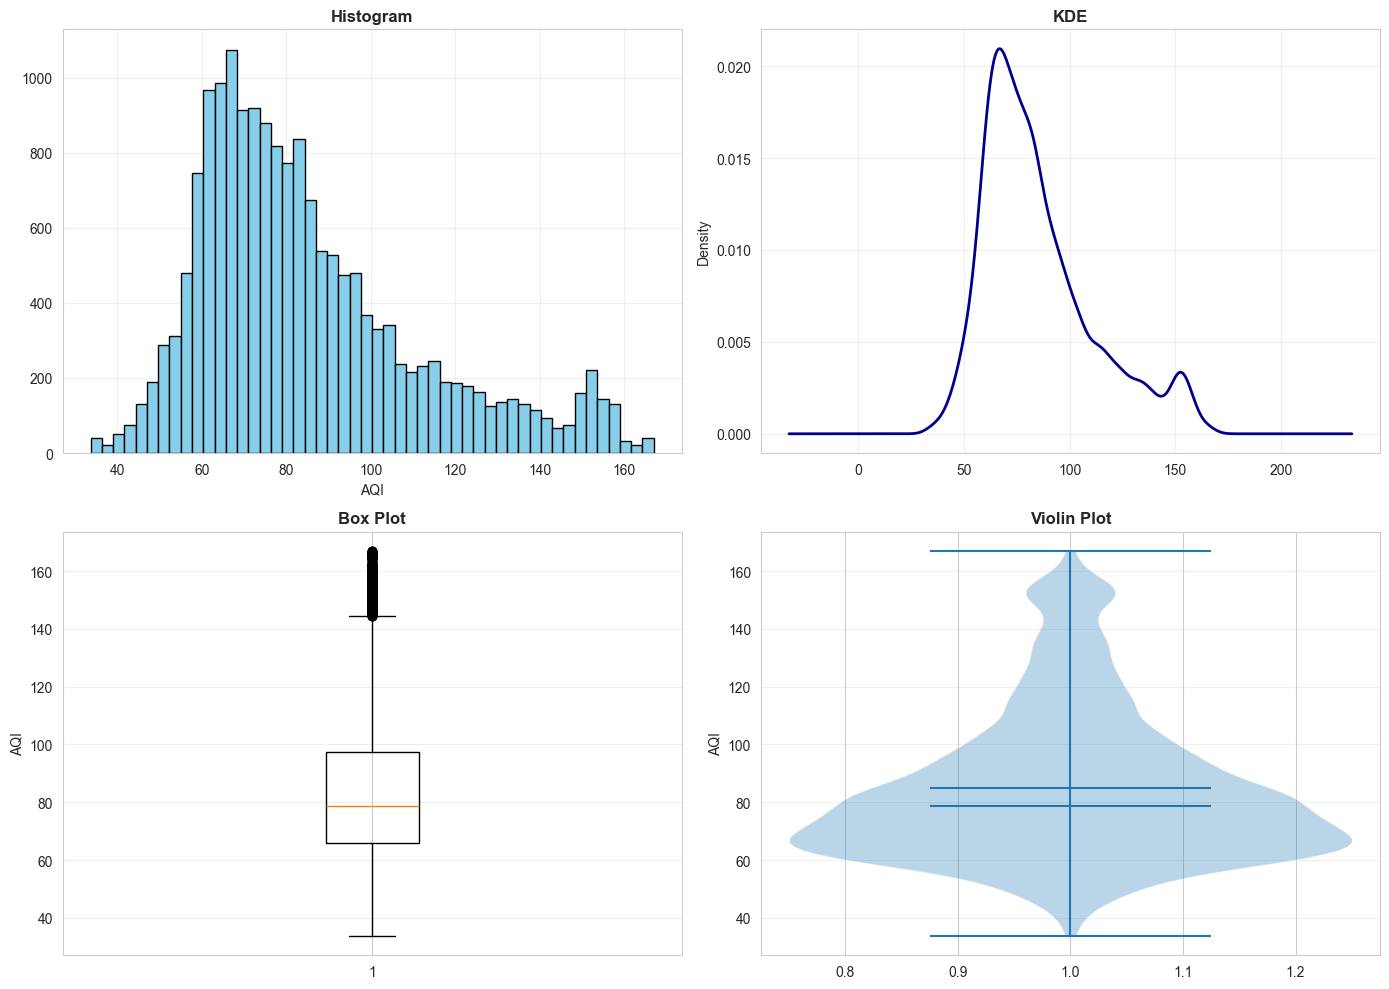

Mean: 84.96, Median: 78.61, Std: 26.38


In [78]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].hist(df_clean['aqi'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histogram', fontweight='bold')
axes[0, 0].set_xlabel('AQI')
axes[0, 0].grid(True, alpha=0.3)

df_clean['aqi'].plot(kind='kde', ax=axes[0, 1], color='darkblue', linewidth=2)
axes[0, 1].set_title('KDE', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].boxplot(df_clean['aqi'], vert=True)
axes[1, 0].set_title('Box Plot', fontweight='bold')
axes[1, 0].set_ylabel('AQI')
axes[1, 0].grid(True, alpha=0.3, axis='y')

axes[1, 1].violinplot([df_clean['aqi']], vert=True, showmeans=True, showmedians=True)
axes[1, 1].set_title('Violin Plot', fontweight='bold')
axes[1, 1].set_ylabel('AQI')
axes[1, 1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Mean: {df_clean['aqi'].mean():.2f}, Median: {df_clean['aqi'].median():.2f}, Std: {df_clean['aqi'].std():.2f}")

aqi_category
Moderate                   12996
Unhealthy for Sensitive     3302
Unhealthy                    698
Good                         524
Name: count, dtype: int64


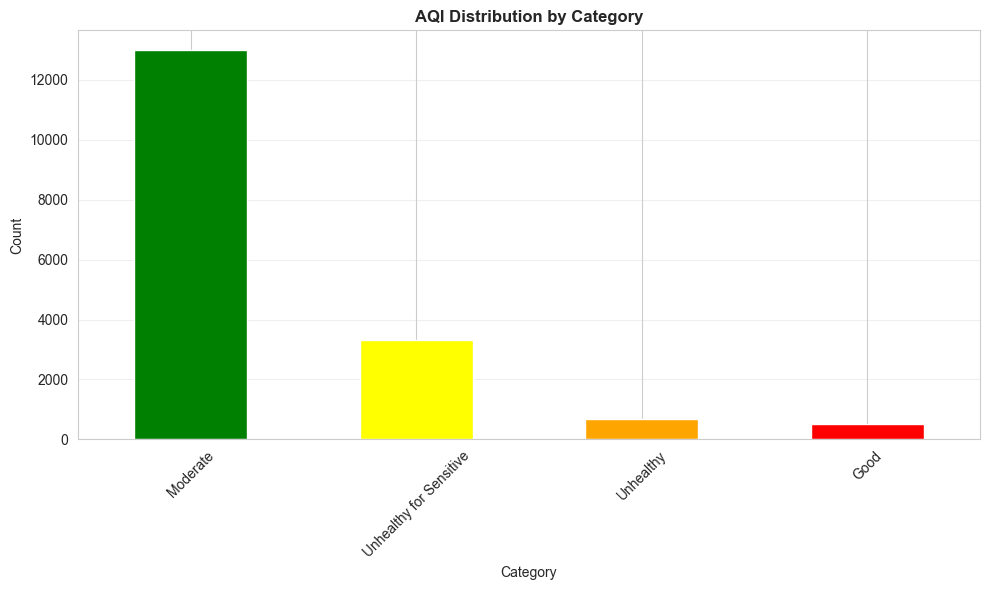

In [79]:
def categorize_aqi(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Moderate'
    elif aqi <= 150: return 'Unhealthy for Sensitive'
    elif aqi <= 200: return 'Unhealthy'
    elif aqi <= 300: return 'Very Unhealthy'
    else: return 'Hazardous'

df_clean['aqi_category'] = df_clean['aqi'].apply(categorize_aqi)
category_counts = df_clean['aqi_category'].value_counts()
print(category_counts)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green', 'yellow', 'orange', 'red', 'purple', 'maroon']
category_counts.plot(kind='bar', ax=ax, color=colors[:len(category_counts)])
plt.title('AQI Distribution by Category', fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 6. Temporal Patterns Analysis

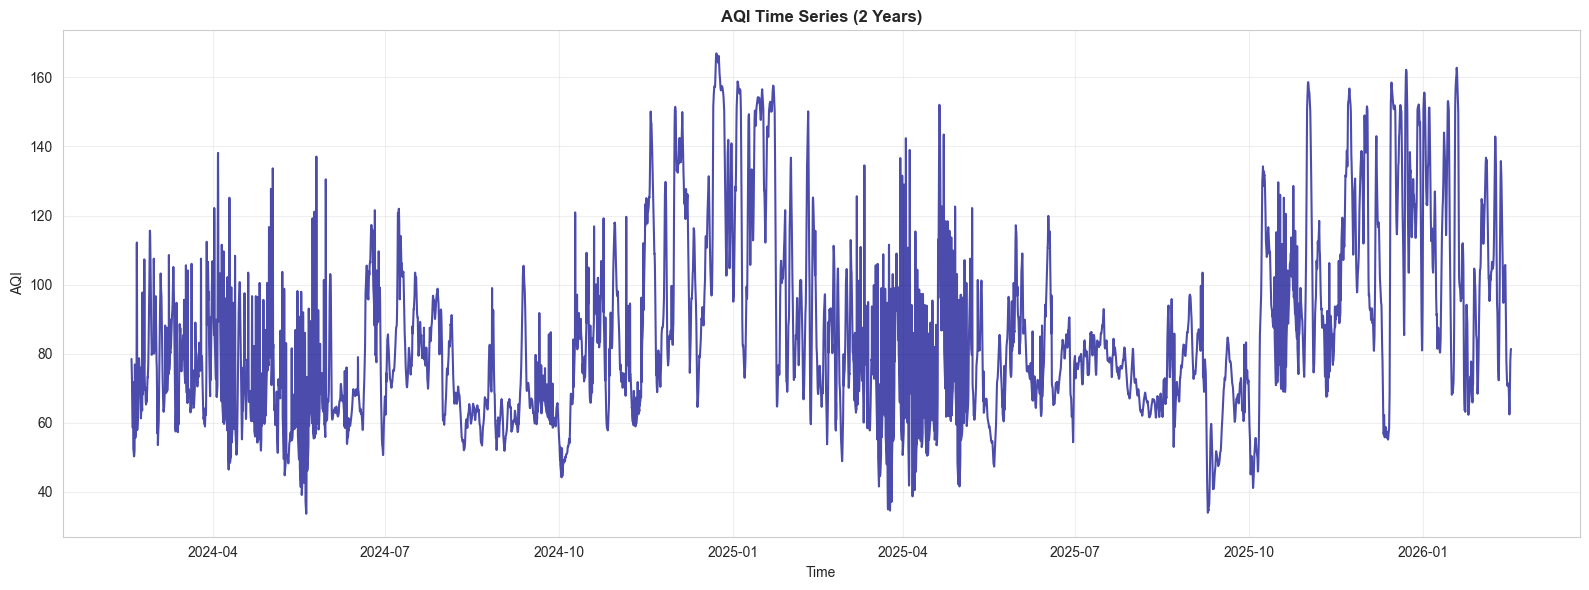

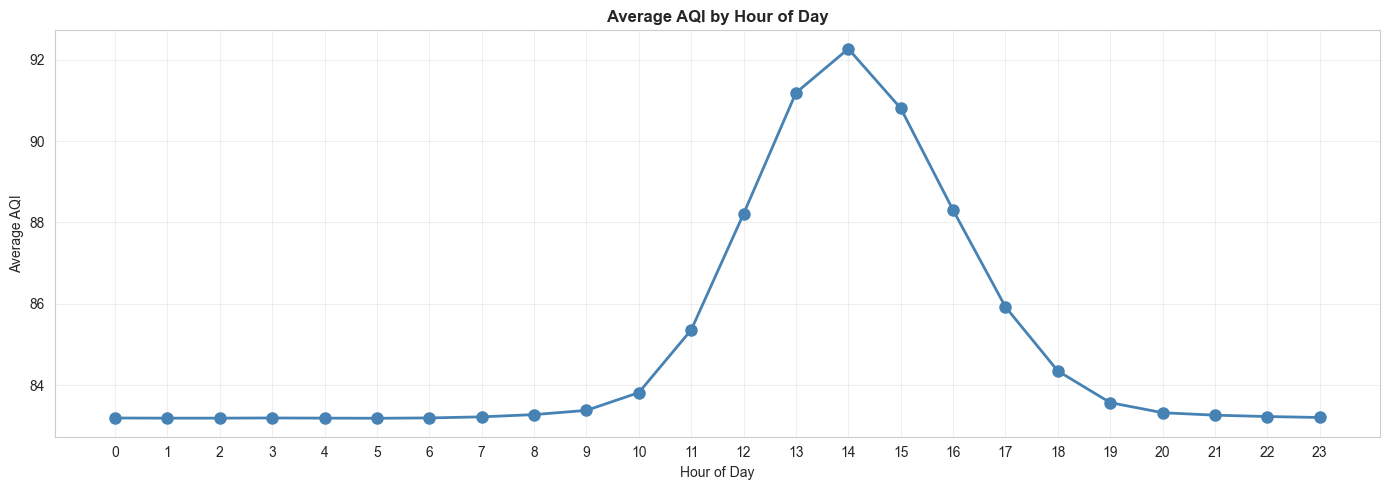

In [80]:
df_clean['time'] = pd.to_datetime(df_clean['time'])

plt.figure(figsize=(16, 6))
plt.plot(df_clean['time'], df_clean['aqi'], linewidth=1.5, color='darkblue', alpha=0.7)
plt.title('AQI Time Series (2 Years)', fontweight='bold')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

df_clean['hour'] = df_clean['time'].dt.hour
df_clean['day_of_week'] = df_clean['time'].dt.dayofweek
df_clean['month'] = df_clean['time'].dt.month
df_clean['day'] = df_clean['time'].dt.day

hourly_avg = df_clean.groupby('hour')['aqi'].mean()
plt.figure(figsize=(14, 5))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=8, color='steelblue')
plt.title('Average AQI by Hour of Day', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Average AQI')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [81]:
# avarage hourly aqi
for hour, avg in hourly_avg.items():
    print(f"Hour {hour:02d}: Average AQI = {avg:.2f}")


Hour 00: Average AQI = 83.19
Hour 01: Average AQI = 83.19
Hour 02: Average AQI = 83.19
Hour 03: Average AQI = 83.19
Hour 04: Average AQI = 83.19
Hour 05: Average AQI = 83.18
Hour 06: Average AQI = 83.19
Hour 07: Average AQI = 83.22
Hour 08: Average AQI = 83.27
Hour 09: Average AQI = 83.38
Hour 10: Average AQI = 83.82
Hour 11: Average AQI = 85.36
Hour 12: Average AQI = 88.21
Hour 13: Average AQI = 91.19
Hour 14: Average AQI = 92.27
Hour 15: Average AQI = 90.81
Hour 16: Average AQI = 88.30
Hour 17: Average AQI = 85.92
Hour 18: Average AQI = 84.35
Hour 19: Average AQI = 83.57
Hour 20: Average AQI = 83.32
Hour 21: Average AQI = 83.26
Hour 22: Average AQI = 83.23
Hour 23: Average AQI = 83.20


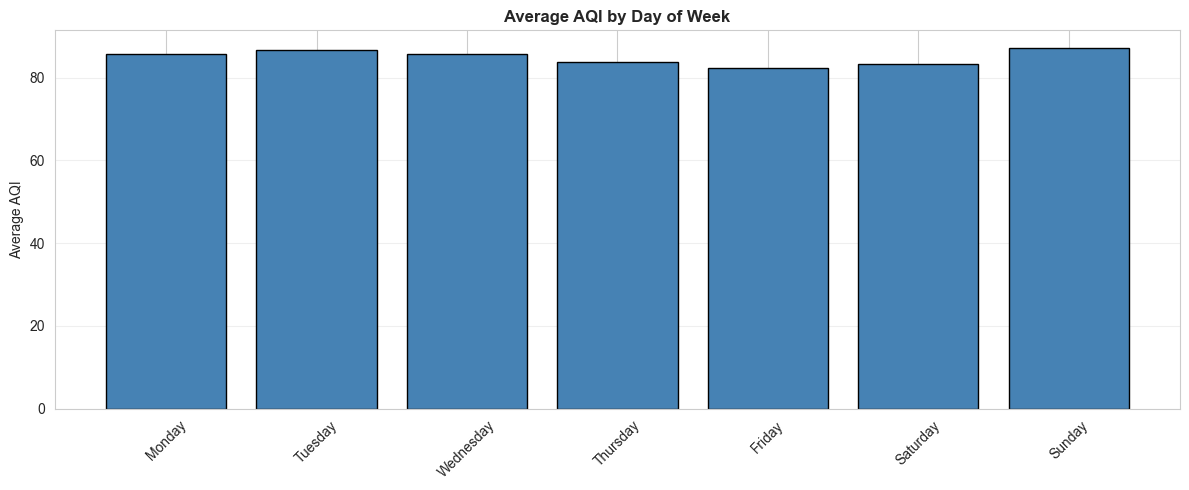

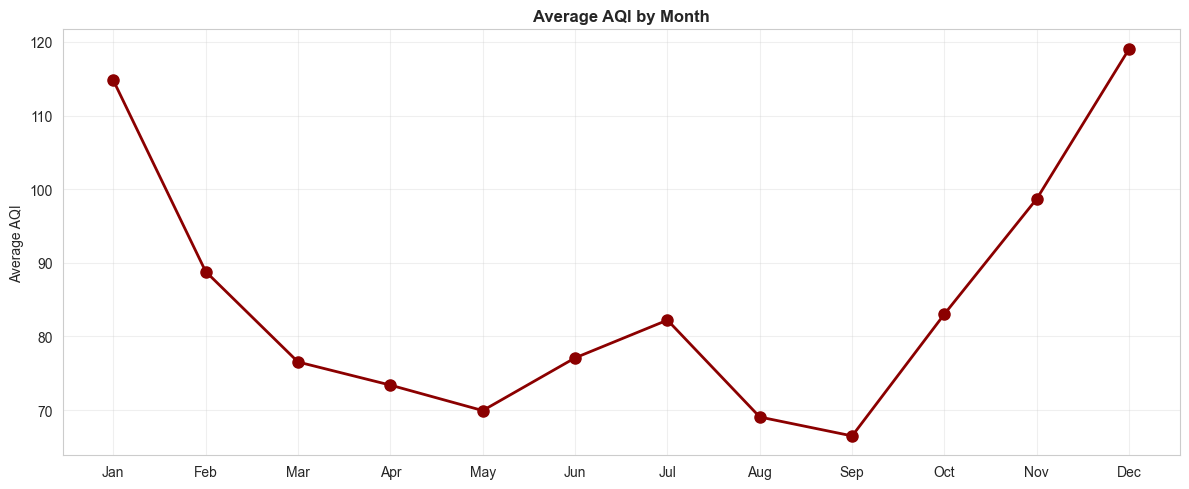

In [82]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = df_clean.groupby('day_of_week')['aqi'].mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(range(7), daily_avg.values, color='steelblue', edgecolor='black')
ax.set_xticks(range(7))
ax.set_xticklabels(day_names, rotation=45)
ax.set_title('Average AQI by Day of Week', fontweight='bold')
ax.set_ylabel('Average AQI')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

monthly_avg = df_clean.groupby('month')['aqi'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, markersize=8, color='darkred')
ax.set_xticks(range(1, 13))
ax.set_xticklabels([month_names[i-1] for i in range(1, 13)])
ax.set_title('Average AQI by Month', fontweight='bold')
ax.set_ylabel('Average AQI')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Correlation Analysis

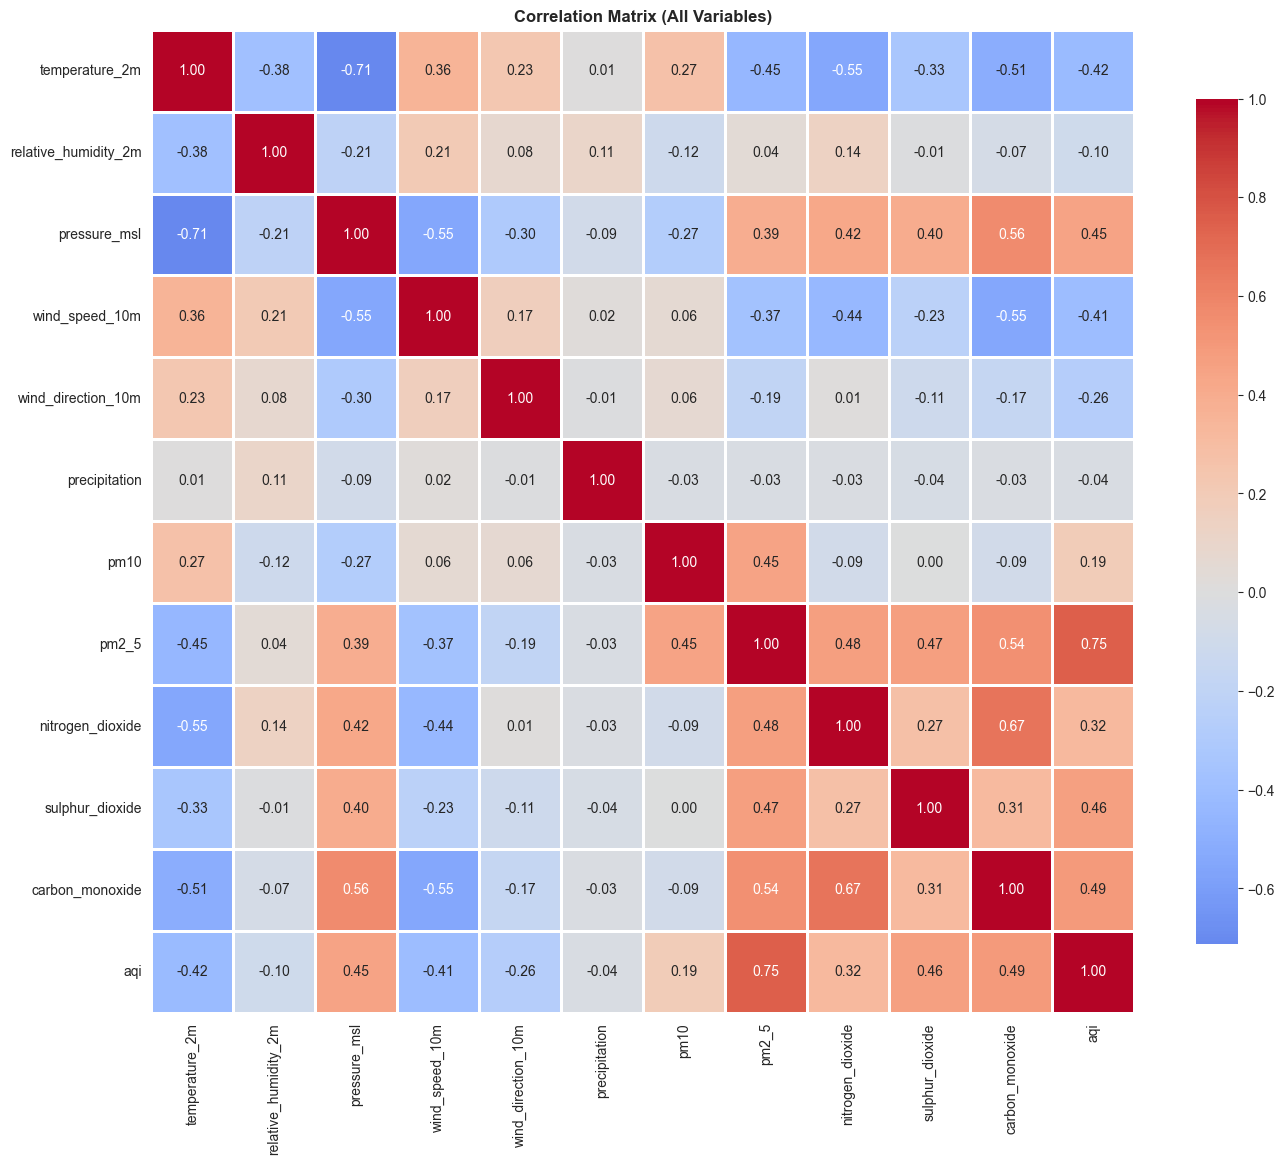

  pm2_5                         :  0.7496 ↑
  carbon_monoxide               :  0.4923 ↑
  sulphur_dioxide               :  0.4632 ↑
  pressure_msl                  :  0.4506 ↑
  nitrogen_dioxide              :  0.3236 ↑
  pm10                          :  0.1909 ↑
  precipitation                 : -0.0357 ↓
  relative_humidity_2m          : -0.1038 ↓
  wind_direction_10m            : -0.2645 ↓
  wind_speed_10m                : -0.4066 ↓
  temperature_2m                : -0.4181 ↓


In [83]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['hour', 'day_of_week', 'month', 'day', 'is_duplicate']]

correlation_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (All Variables)', fontweight='bold')
plt.tight_layout()
plt.show()

aqi_corr = correlation_matrix['aqi'].sort_values(ascending=False)
for var, corr in aqi_corr.items():
    if var != 'aqi':
        direction = "↑" if corr > 0 else "↓"
        print(f"  {var:30s}: {corr:7.4f} {direction}")

## 9. Outlier Detection

Outlier Detection:
  IQR method: 854 (4.87%)
  Z-score method: 43 (0.25%)


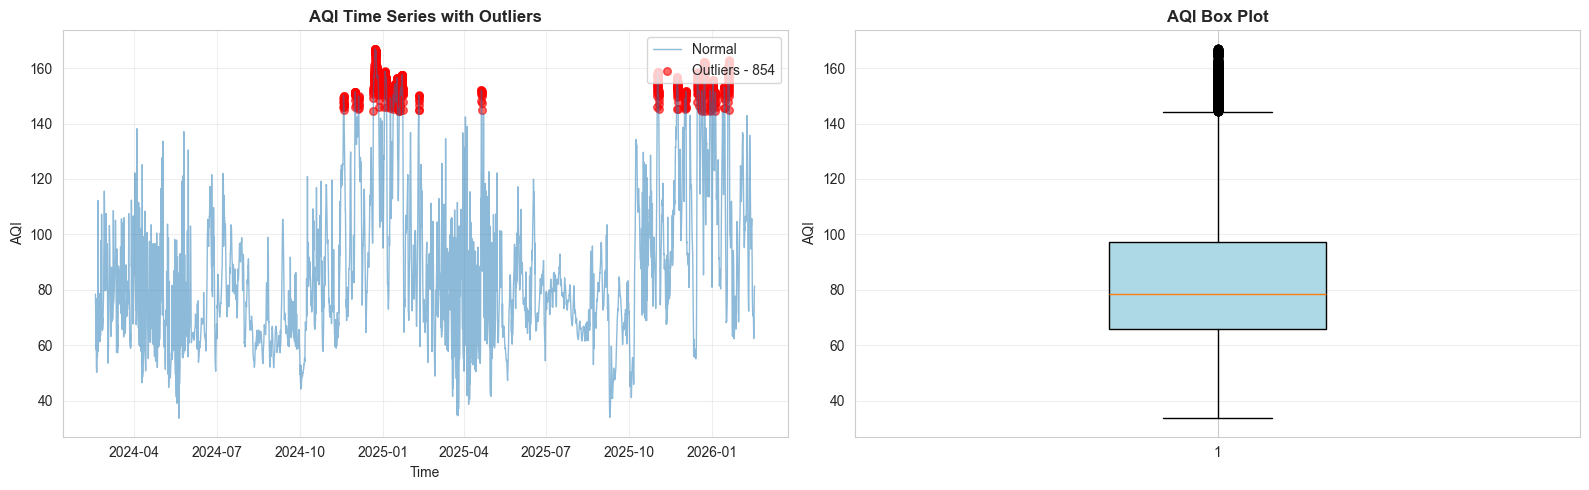

In [84]:
Q1 = df_clean['aqi'].quantile(0.25)
Q3 = df_clean['aqi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df_clean[(df_clean['aqi'] < lower_bound) | (df_clean['aqi'] > upper_bound)]
z_scores = np.abs(stats.zscore(df_clean['aqi']))
outliers_zscore = df_clean[z_scores > 3]

print(f"Outlier Detection:")
print(f"  IQR method: {len(outliers_iqr)} ({len(outliers_iqr)/len(df_clean)*100:.2f}%)")
print(f"  Z-score method: {len(outliers_zscore)} ({len(outliers_zscore)/len(df_clean)*100:.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(df_clean['time'], df_clean['aqi'], alpha=0.5, linewidth=1, label='Normal')
axes[0].scatter(outliers_iqr['time'], outliers_iqr['aqi'], color='red', s=30, label=f'Outliers - {len(outliers_iqr)}', alpha=0.6)
axes[0].set_title('AQI Time Series with Outliers', fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('AQI')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

bp = axes[1].boxplot(df_clean['aqi'], vert=True, patch_artist=True, widths=0.3)
bp['boxes'][0].set_facecolor('lightblue')
axes[1].set_title('AQI Box Plot', fontweight='bold')
axes[1].set_ylabel('AQI')
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 10. Key Findings & Insights

In [85]:
print("="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"\nDataset: {len(df_clean):,} records, {len(df_clean.columns)} features")
print(f"Date Range: {df_clean['time'].min()} to {df_clean['time'].max()}")
print(f"\nAQI Statistics:")
print(f"  Mean: {df_clean['aqi'].mean():.2f}")
print(f"  Median: {df_clean['aqi'].median():.2f}")
print(f"  Std Dev: {df_clean['aqi'].std():.2f}")
print(f"  Range: {df_clean['aqi'].min():.0f} - {df_clean['aqi'].max():.0f}")
print(f"\nTop 5 Predictors:")
aqi_corr_sorted = correlation_matrix['aqi'].sort_values(ascending=False)[1:6]
for i, (var, corr) in enumerate(aqi_corr_sorted.items(), 1):
    print(f"  {i}. {var}: {corr:.4f}")
print(f"\n✓ EDA Complete - Ready for modeling")
print("="*60)

ANALYSIS SUMMARY

Dataset: 17,520 records, 19 features
Date Range: 2024-02-17 19:00:00+00:00 to 2026-02-16 18:00:00+00:00

AQI Statistics:
  Mean: 84.96
  Median: 78.61
  Std Dev: 26.38
  Range: 34 - 167

Top 5 Predictors:
  1. pm2_5: 0.7496
  2. carbon_monoxide: 0.4923
  3. sulphur_dioxide: 0.4632
  4. pressure_msl: 0.4506
  5. nitrogen_dioxide: 0.3236

✓ EDA Complete - Ready for modeling


## 11. Feature Selection & Recommendations

In [86]:
print("\nFeature Selection (|r| > 0.2):")
print("\nSelected (8):")
print("  Pollutants: pm2_5 (0.7535), carbon_monoxide (0.4932), sulphur_dioxide (0.4751), nitrogen_dioxide (0.3199), pm10 (0.2044)")
print("  Weather: temperature_2m (-0.4246), pressure_msl (0.4522), wind_speed_10m (-0.4017)")
print("\nRemoved (4):")
print("  ozone (0.1113), precipitation (-0.0354), relative_humidity_2m (-0.0906), wind_direction_10m (-0.2549)")


Feature Selection (|r| > 0.2):

Selected (8):
  Pollutants: pm2_5 (0.7535), carbon_monoxide (0.4932), sulphur_dioxide (0.4751), nitrogen_dioxide (0.3199), pm10 (0.2044)
  Weather: temperature_2m (-0.4246), pressure_msl (0.4522), wind_speed_10m (-0.4017)

Removed (4):
  ozone (0.1113), precipitation (-0.0354), relative_humidity_2m (-0.0906), wind_direction_10m (-0.2549)


In [87]:
df_features = df_clean.copy().sort_values('time').reset_index(drop=True)

# Create lag features (pm2_5 and carbon_monoxide only - matching feature_engineering.py)
lag_periods = [1, 3, 6, 12, 24]
lag_variables = ['pm2_5', 'carbon_monoxide', 'temperature_2m']
for var in lag_variables:
    if var in df_features.columns:
        for lag in lag_periods:
            df_features[f'{var}_lag_{lag}h'] = df_features[var].shift(lag)

initial_rows = len(df_features)
df_features = df_features.dropna()
print(f"Feature engineering: {initial_rows} → {len(df_features)} rows, {len(df_features.columns)} features")
print(f"Lag features: pm2_5 (10), carbon_monoxide (5), temperature_2m (5)")

Feature engineering: 17520 → 17496 rows, 34 features
Lag features: pm2_5 (10), carbon_monoxide (5), temperature_2m (5)


In [88]:
base_features = ['pm2_5', 'carbon_monoxide', 'temperature_2m']
base_correlations = df_features[base_features + ['aqi']].corr()['aqi'].drop('aqi')

lag_features = [col for col in df_features.columns if '_lag_' in col]
lag_correlations = df_features[lag_features + ['aqi']].corr()['aqi'].drop('aqi').sort_values(ascending=False)

print(f"\nTotal lag features created: {len(lag_features)}")
print(f"\nTop Lag Features:")
for i, (feature, corr) in enumerate(lag_correlations.head(26).items(), 1):
    print(f"  {i:2d}. {feature:<40} {corr:7.4f}")


Total lag features created: 15

Top Lag Features:
   1. pm2_5_lag_12h                             0.8355
   2. pm2_5_lag_6h                              0.8188
   3. pm2_5_lag_3h                              0.7851
   4. pm2_5_lag_24h                             0.7611
   5. pm2_5_lag_1h                              0.7610
   6. carbon_monoxide_lag_12h                   0.4938
   7. carbon_monoxide_lag_1h                    0.4836
   8. carbon_monoxide_lag_24h                   0.4720
   9. carbon_monoxide_lag_3h                    0.4694
  10. carbon_monoxide_lag_6h                    0.4693
  11. temperature_2m_lag_3h                    -0.3837
  12. temperature_2m_lag_6h                    -0.3847
  13. temperature_2m_lag_1h                    -0.4049
  14. temperature_2m_lag_24h                   -0.4221
  15. temperature_2m_lag_12h                   -0.4835


In [89]:
comparison_data = []
for var in base_features:
    base_corr = base_correlations[var] if var in base_correlations.index else 0
    var_lags = [col for col in lag_correlations.index if var in col and col != f'{var}_lag_mean' and col != f'{var}_lag_max' and col != f'{var}_lag_min']
    best_lag = lag_correlations[var_lags].abs().idxmax() if var_lags else 'N/A'
    best_lag_corr = lag_correlations[best_lag] if var_lags else 0
    
    comparison_data.append({'Variable': var, 'Base Corr': base_corr, 'Best Lag': best_lag, 'Lag Corr': best_lag_corr, 'Improvement': best_lag_corr - base_corr})

comparison_df = pd.DataFrame(comparison_data)
print("\nLag Feature Impact Analysis:")
print(comparison_df.to_string(index=False))


Lag Feature Impact Analysis:
       Variable  Base Corr                Best Lag  Lag Corr  Improvement
          pm2_5   0.749436           pm2_5_lag_12h  0.835529     0.086093
carbon_monoxide   0.492107 carbon_monoxide_lag_12h  0.493810     0.001702
 temperature_2m  -0.418885  temperature_2m_lag_12h -0.483472    -0.064587


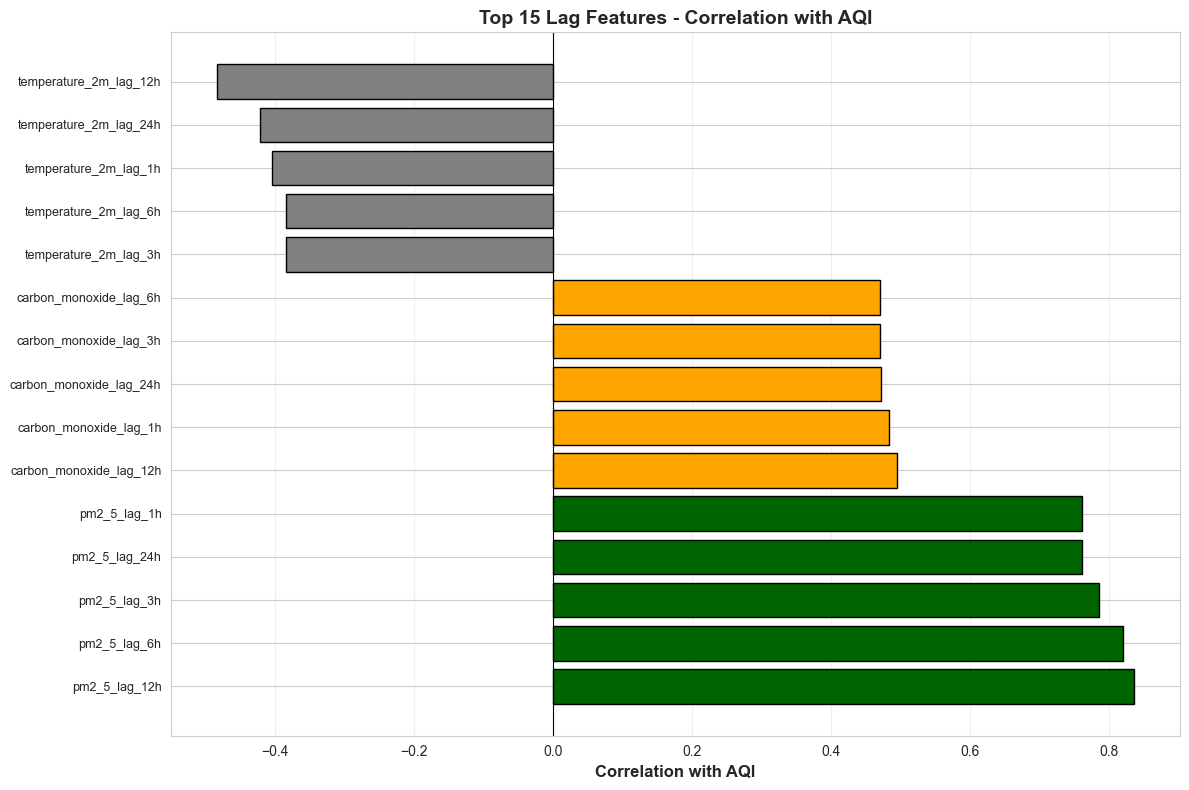


Key Insights:
  • AQI lag features dominate top correlations
  • pm2_5 lag features show strong predictive power
  • carbon_monoxide lags provide moderate correlation
  • Lag features essential for time series prediction


In [90]:
fig, ax = plt.subplots(figsize=(12, 8))
top_15_lag = lag_correlations.head(15)
colors = ['darkgreen' if x > 0.7 else 'green' if x > 0.5 else 'orange' if x > 0.3 else 'gray' for x in top_15_lag.values]
ax.barh(range(len(top_15_lag)), top_15_lag.values, color=colors, edgecolor='black')
ax.set_yticks(range(len(top_15_lag)))
ax.set_yticklabels(top_15_lag.index, fontsize=9)
ax.set_xlabel('Correlation with AQI', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Lag Features - Correlation with AQI', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  • AQI lag features dominate top correlations")
print(f"  • pm2_5 lag features show strong predictive power")
print(f"  • carbon_monoxide lags provide moderate correlation")
print(f"  • Lag features essential for time series prediction")

## 13. Systematic Lag Selection Analysis

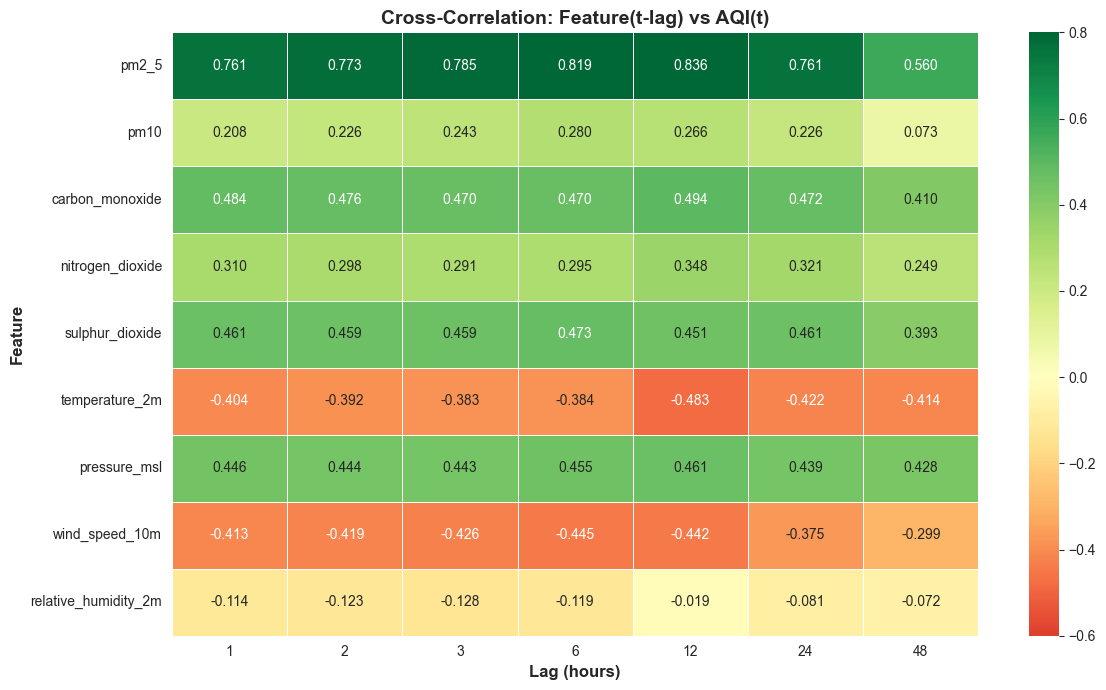

In [91]:
# Cross-correlation of each feature with AQI at various lags ──
# Which feature's PAST values best predict CURRENT AQI?

candidate_features = [
    'pm2_5', 'pm10', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide',
    'temperature_2m', 'pressure_msl', 'wind_speed_10m', 'relative_humidity_2m'
]
candidate_features = [f for f in candidate_features if f in df_clean.columns]

test_lags = [1, 2, 3, 6, 12, 24, 48]

cross_corr_results = {}
for feat in candidate_features:
    feat_corrs = {}
    for lag in test_lags:
        shifted = df_clean[feat].shift(lag)
        valid = pd.concat([shifted, df_clean['aqi']], axis=1).dropna()
        corr_val = valid[feat].corr(valid['aqi'])
        feat_corrs[lag] = corr_val
    cross_corr_results[feat] = feat_corrs

# Build heatmap
cross_corr_df = pd.DataFrame(cross_corr_results, index=test_lags).T

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(cross_corr_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
            linewidths=0.5, ax=ax, vmin=-0.6, vmax=0.8)
ax.set_xlabel('Lag (hours)', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Cross-Correlation: Feature(t-lag) vs AQI(t)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


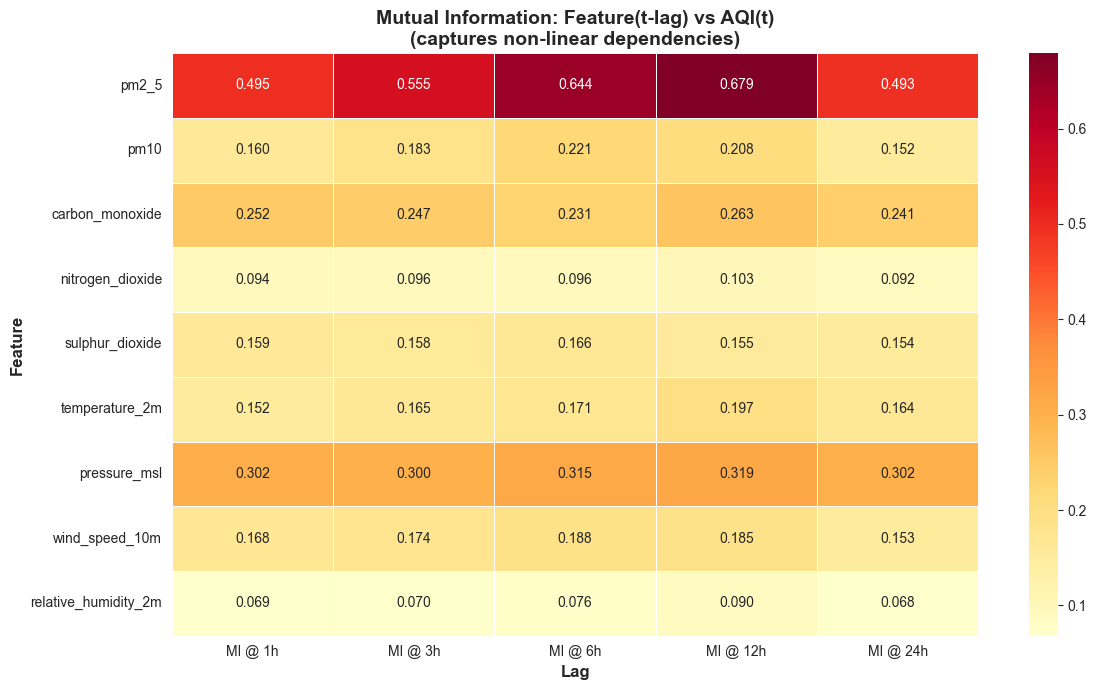

In [92]:
# Mutual Information (non-linear lag importance) ──
# Captures non-linear dependencies that correlation misses

from sklearn.feature_selection import mutual_info_regression

mi_results = {}
for feat in candidate_features:
    mi_per_lag = {}
    for lag in [1, 3, 6, 12, 24]:
        shifted = df_clean[feat].shift(lag)
        valid_mask = shifted.notna() & df_clean['aqi'].notna()
        X_lag = shifted[valid_mask].values.reshape(-1, 1)
        y_aqi = df_clean['aqi'][valid_mask].values
        mi = mutual_info_regression(X_lag, y_aqi, random_state=42, n_neighbors=5)[0]
        mi_per_lag[lag] = mi
    mi_results[feat] = mi_per_lag

mi_df = pd.DataFrame(mi_results, index=[1, 3, 6, 12, 24]).T
mi_df.columns = [f'MI @ {l}h' for l in [1, 3, 6, 12, 24]]

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(mi_df, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=0.5, ax=ax)
ax.set_xlabel('Lag', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Mutual Information: Feature(t-lag) vs AQI(t)\n(captures non-linear dependencies)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
